In [31]:
%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

In [22]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()
    # log_p: (n, c, h, w)
    log_p = F.log_softmax(input)
    # log_p: (n*h*w, c)
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p, target, weight=weight, size_average=False)
    if size_average:
        loss /= mask.data.sum()
    return loss

In [6]:
# https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [25]:
class fcn_32(nn.Module):
    def __init__(self, class_num=21):
        super(fcn_32, self).__init__()
        self.conv = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, 3, padding=100),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/2
            
            # conv2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/4
            
            # conv3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/8
            
            # conv4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/16
            
            # conv4
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/16
        )
        
        self.f_conv = nn.Sequential(
            # fully convolutional 1
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            
            # fully convolutional 2
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
        )
        
        self.up_sampling = nn.Sequential(
            nn.Conv2d(4096, class_num, 1),
            nn.ConvTranspose2d(class_num, class_num, 64,
                               stride=32, bias=False)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)
                
    def forward(self, x):
        h = x
        h = self.conv(h)
        h = self.f_conv(h)
        h = self.up_sampling(h)
        h = h[:, :, 19:19 + x.size()[2], 19:19 + x.size()[3]].contiguous()
        
        return h
    
    def transfer_from_vgg16(self, vgg16):
        for l1, l2 in zip(vgg16.features, self.conv):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for l1, l2 in zip(vgg16.classifier, self.f_conv):
            if isinstance(l1, nn.Linear) and isinstance(l2, nn.Conv2d):
                l2.weight.data = l1.weight.data.view(l2.weight.size())
                l2.bias.data = l1.bias.data.view(l2.bias.size())

In [23]:
vgg = models.vgg16(pretrained=True)

In [26]:
fcn = fcn_32()
fcn.transfer_from_vgg16(vgg)

In [219]:
from PIL import Image
import os.path as osp
import os

EXTENSIONS = ['.jpg', '.png']
def load_image(file):
    return Image.open(file)

def is_image(filename):
    return any(filename.endswith(ext) for ext in EXTENSIONS)

def image_path(root, basename, extension):
    return os.path.join(root, basename+extension)

def image_basename(filename):
    return os.path.basename(os.path.splitext(filename)[0])

class VOC12(Dataset):

    def __init__(self, root='./', input_transform=None, target_transform=None):
        self.images_root = os.path.join(root, 'VOCdevkit/VOC2012/JPEGImages/')
        self.labels_root = os.path.join(root, 'VOCdevkit/VOC2012/SegmentationClass/')

        self.filenames = [image_basename(f) for f in os.listdir(self.labels_root) if is_image(f)]
        self.filenames.sort()

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        filename = self.filenames[index]

        with open(image_path(self.images_root, filename, '.jpg'), 'rb') as f:
            image = load_image(f).convert('RGB')
        with open(image_path(self.labels_root, filename, '.png'), 'rb') as f:
            label = load_image(f).convert('P')

#         image = np.asarray(image, dtype=np.float32)
#         label = np.asarray(label, dtype=np.float32)
        #label = label.reshape((label.shape[0], label.shape[1], 1))
#         print(label.shape)
        if self.input_transform is not None:
            image = self.input_transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)
        print(label)
        return image, label

    def __len__(self):
        return len(self.filenames)


( 0 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
           ...             ⋱             ...          
  0.0588  0.0588  0.0588  ...   0.0000  0.0000  0.0000
  0.0588  0.0588  0.0588  ...   0.0000  0.0000  0.0000
  0.0588  0.0588  0.0588  ...   0.0000  0.0000  0.0000
[torch.FloatTensor of size 1x227x227]

(3, 227, 227)
(227, 227)


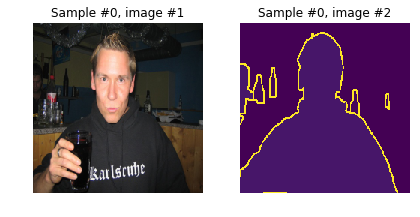

In [220]:
def show(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
def show_label(img):
    npimg = img.numpy()
    print(npimg[0].shape)
    plt.imshow(np.transpose(npimg, (1,2,0))[:,:,0], interpolation='nearest')
    
trans = transforms.Compose([transforms.Scale((227,227)),
                            transforms.ToTensor()
                            ])

train_dataset = VOC12(input_transform=trans, target_transform=trans)
vis_dataloader = DataLoader(train_dataset
                            #,shuffle=False,
                            #num_workers=1,
                            #batch_size=1
                           )

# img, label = next(iter(vis_dataloader))
i=10
img, label = train_dataset[i]
ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.set_title('Sample #{0}, image #{1}'.format(0, 1))
ax.axis('off')
show(img)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Sample #{0}, image #{1}'.format(0, 2))
ax.axis('off')
show_label(label)
plt.show()

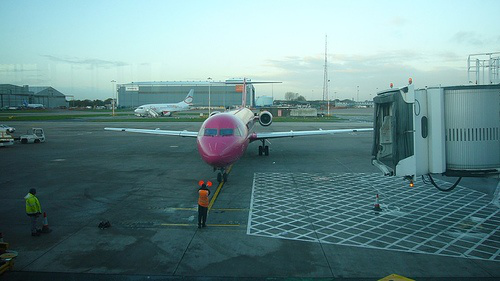

In [171]:
Image.open('./VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg').convert('RGB')

In [75]:
os.path.join('./', 'VOCdevkit/VOC2012/JPEGImages/2007_000032','.jpg')

'./VOCdevkit/VOC2012/JPEGImages/2007_000032/.jpg'